# Loan approval analysis

The aim of this project is to conduct exploratory analysis and run machine learning algorithms to create a classifier that decides whether to accept a loan application. In addition, determining the most important variables/features affecting the final decision.

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

plt.ioff()

In [2]:
# load dataset
df = pd.read_csv(r'C:\Analiza danych\Datasety\finance_loan.csv')

In [3]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Dataset details:
Dataset contains some information about loans and their acceptance.

Variables description:
- **Loan_ID**: unique identification number,
- **Gender**: gender of applicant,
- **Married**: marriage status of applicant,
- **Dependents**: number of dependents of the applicant,
- **Education**: status of education
- **Self_Employed**: whether the applicant is self-employed,
- **ApplicantIncome**: income of the applicant,
- **CoapplicantIncome**: income of the coapplicant,
- **LoanAmount**: loan amount,
- **Loan_Amount_Term**: loan term in months,
- **Credit_History**: whether the applicant has a credit history,
- **Property_Area**: whether the property is located in urban or rural area,
- **Loan_Status**: whether the application has been approved.



In [4]:
print(f'Dataset size: {df.shape}')
df.info()

Dataset size: (614, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [5]:
# drop unnecessary variable
df = df.drop(['Loan_ID'], axis = 1)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


Looking at the basic statistics, we can see that the income variables most likely have extreme outliers.\
Just look at the quartiles, maximum values, and standard deviation.

In [7]:
df.describe(include = ['O']).T

,count,unique,top,freq
Gender,601,2,Male,489
Married,611,2,Yes,398
Dependents,599,4,0,345
Education,614,2,Graduate,480
Self_Employed,582,2,No,500
Property_Area,614,3,Semiurban,233
Loan_Status,614,2,Y,422


Looking at categorical variables and amount of their unique values we can assume that there are no wrong values.

In [8]:
df['Loan_Amount_Term'].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

We also see that ```Loan_Amount_Term``` is most propably a categorical variable so we will change its data type after handling with missing values.

In [9]:
df.isna().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

The number of missing values is different for each variable, so we will use imputation.

In [10]:
# most frequent value for categorical variables
cat_cols = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History', 'Loan_Amount_Term']

df[cat_cols] = df[cat_cols].fillna(df.mode().iloc[0])

In [11]:
# mean for numerical variable
df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace = True)

In [12]:
df.isna().any()

Gender               False
Married              False
Dependents           False
Education            False
Self_Employed        False
ApplicantIncome      False
CoapplicantIncome    False
LoanAmount           False
Loan_Amount_Term     False
Credit_History       False
Property_Area        False
Loan_Status          False
dtype: bool

In [13]:
# change data type for loan term because it represents months
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].astype(int)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    object 
 1   Married            614 non-null    object 
 2   Dependents         614 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      614 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    int32  
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(3), int32(1), int64(1), object(7)
memory usage: 55.3+ KB


**Our data is clean and ready for analysis.**

# Exploratory Data Analysis

## Exploring categorical variables

In [15]:
sns.set_style('darkgrid')

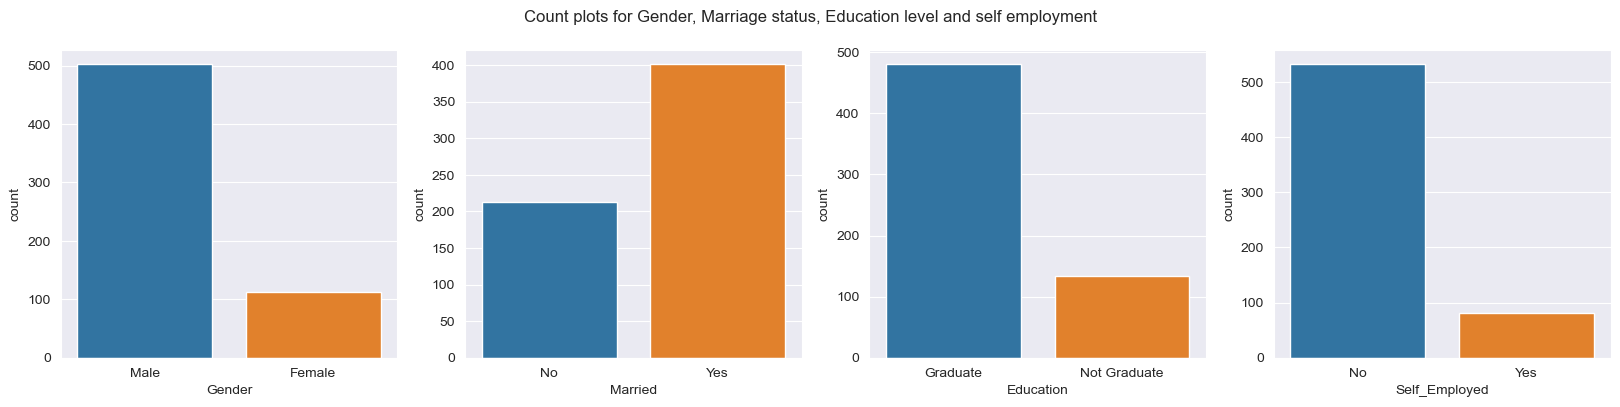

In [16]:
fig, axes = plt.subplots(1, 4, figsize = (20, 4))
fig.suptitle('Count plots for Gender, Marriage status, Education level and self employment')

sns.countplot(ax = axes[0], x = df['Gender'])
sns.countplot(ax = axes[1], x = df['Married'])
sns.countplot(ax = axes[2], x = df['Education'])
sns.countplot(ax = axes[3], x = df['Self_Employed'])

plt.show()

In [17]:
print('Gender proportions (%):')
(df['Gender'].value_counts(normalize = True) * 100).round(2)

Gender proportions (%):


Male      81.76
Female    18.24
Name: Gender, dtype: float64

In [18]:
print('Married proportions (%):')
(df['Married'].value_counts(normalize = True) * 100).round(2)

Married proportions (%):


Yes    65.31
No     34.69
Name: Married, dtype: float64

In [19]:
print('Education proportions (%):')
(df['Education'].value_counts(normalize = True) * 100).round(2)

Education proportions (%):


Graduate        78.18
Not Graduate    21.82
Name: Education, dtype: float64

In [20]:
print('Self-employment proportions (%):')
(df['Self_Employed'].value_counts(normalize = True) * 100).round(2)

Self-employment proportions (%):


No     86.64
Yes    13.36
Name: Self_Employed, dtype: float64

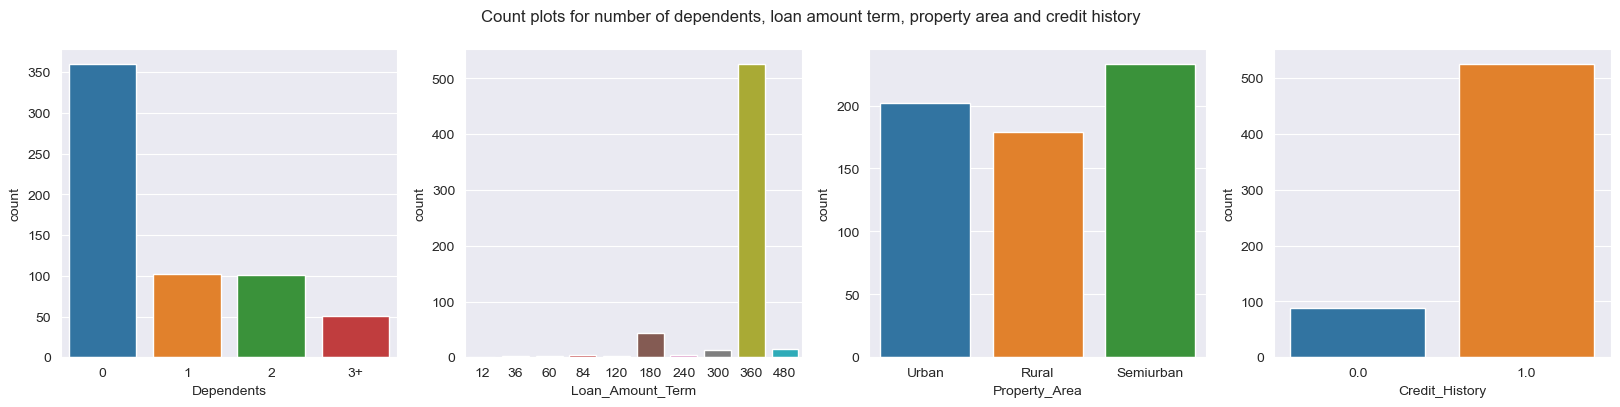

In [21]:
fig, axes = plt.subplots(1, 4, figsize = (20, 4))
fig.suptitle('Count plots for number of dependents, loan amount term, property area and credit history')

sns.countplot(ax = axes[0], x = df['Dependents'])
sns.countplot(ax = axes[1], x = df['Loan_Amount_Term'])
sns.countplot(ax = axes[2], x = df['Property_Area'])
sns.countplot(ax = axes[3], x = df['Credit_History'])

plt.show()

In [22]:
print('Number of dependents proportions (%):')
(df['Dependents'].value_counts(normalize = True) * 100).round(2)

Number of dependents proportions (%):


0     58.63
1     16.61
2     16.45
3+     8.31
Name: Dependents, dtype: float64

In [23]:
print('Loan amount term proportions (%):')
(df['Loan_Amount_Term'].value_counts(normalize = True) * 100).round(2)

Loan amount term proportions (%):


360    85.67
180     7.17
480     2.44
300     2.12
240     0.65
84      0.65
120     0.49
60      0.33
36      0.33
12      0.16
Name: Loan_Amount_Term, dtype: float64

In [24]:
print('Property area proportions (%):')
(df['Property_Area'].value_counts(normalize = True) * 100).round(2)

Property area proportions (%):


Semiurban    37.95
Urban        32.90
Rural        29.15
Name: Property_Area, dtype: float64

In [25]:
print('Credit history proportions (%):')
(df['Credit_History'].value_counts(normalize = True) * 100).round(2)

Credit history proportions (%):


1.0    85.5
0.0    14.5
Name: Credit_History, dtype: float64

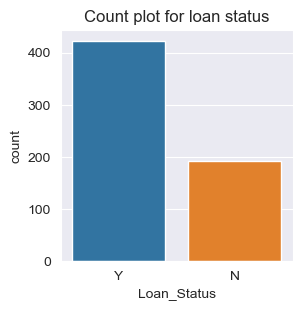

In [26]:
fig = plt.figure(figsize = (3, 3))
sns.countplot(x = 'Loan_Status', data = df)
plt.title('Count plot for loan status')

plt.show()

In [27]:
print('Loan approval proportions (%):')
(df['Loan_Status'].value_counts(normalize = True) * 100).round(2)

Loan approval proportions (%):


Y    68.73
N    31.27
Name: Loan_Status, dtype: float64

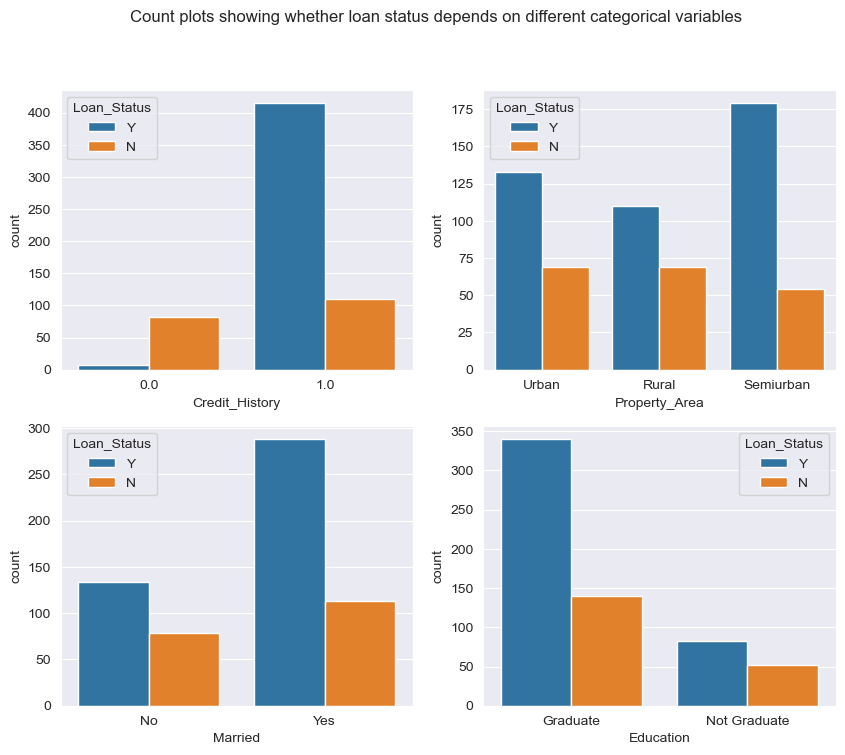

In [28]:
fig, axes = plt.subplots(2, 2, figsize = (10, 8))
plt.suptitle('Count plots showing whether loan status depends on different categorical variables')

sns.countplot(ax = axes[0, 0], x = df['Credit_History'], hue = df['Loan_Status'])
sns.countplot(ax = axes[0, 1], x = df['Property_Area'], hue = df['Loan_Status'])
sns.countplot(ax = axes[1, 0], x = df['Married'], hue = df['Loan_Status'])
sns.countplot(ax = axes[1, 1], x = df['Education'], hue = df['Loan_Status'])

plt.show()

## Exploring numerical variables

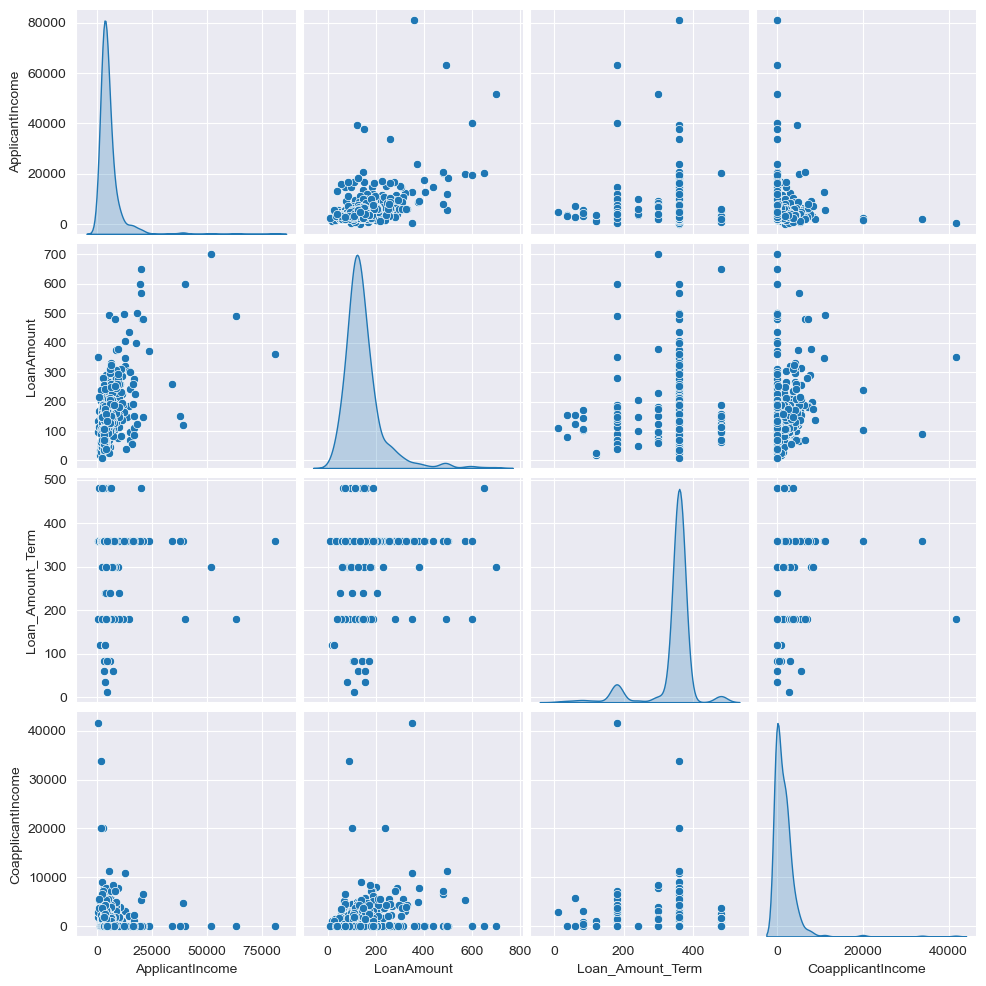

In [29]:
sns.pairplot(data = df, diag_kind = 'kde', vars = ['ApplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'CoapplicantIncome'])
plt.show()

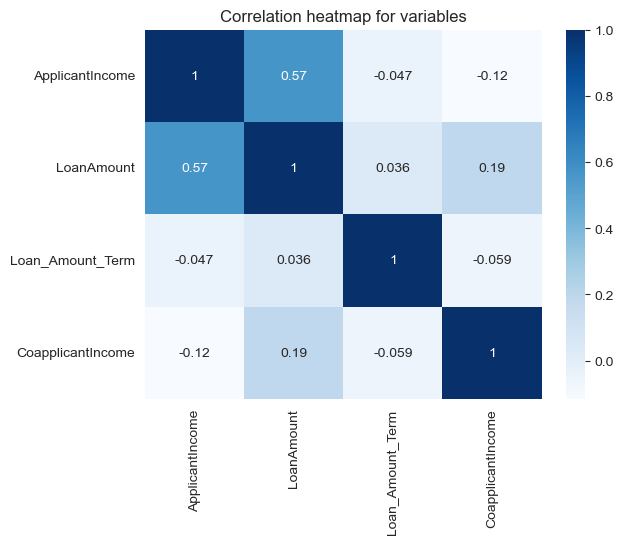

In [30]:
sns.heatmap(df[['ApplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'CoapplicantIncome']].corr(), annot = True, cmap = 'Blues')
plt.title('Correlation heatmap for variables')
plt.show()

LoanAmount and ApplicationIncome are slightly correlated.

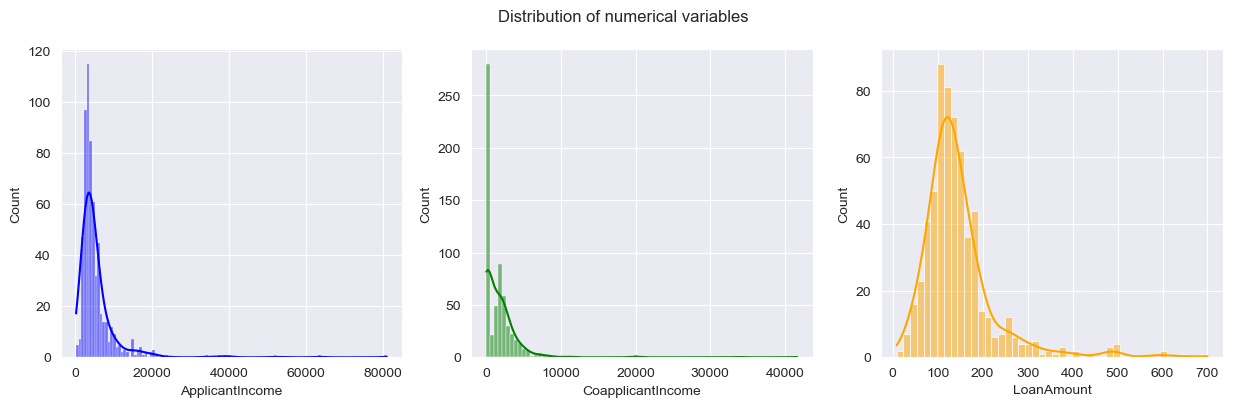

In [31]:
fig, axes = plt.subplots(1, 3, figsize = (15, 4))
fig.suptitle('Distribution of numerical variables')

sns.histplot(ax = axes[0], x = df['ApplicantIncome'], color = 'blue', kde = True)
sns.histplot(ax = axes[1], x = df['CoapplicantIncome'], color = 'green', kde = True)
sns.histplot(ax = axes[2], x = df['LoanAmount'], color = 'orange', kde = True)

plt.show()

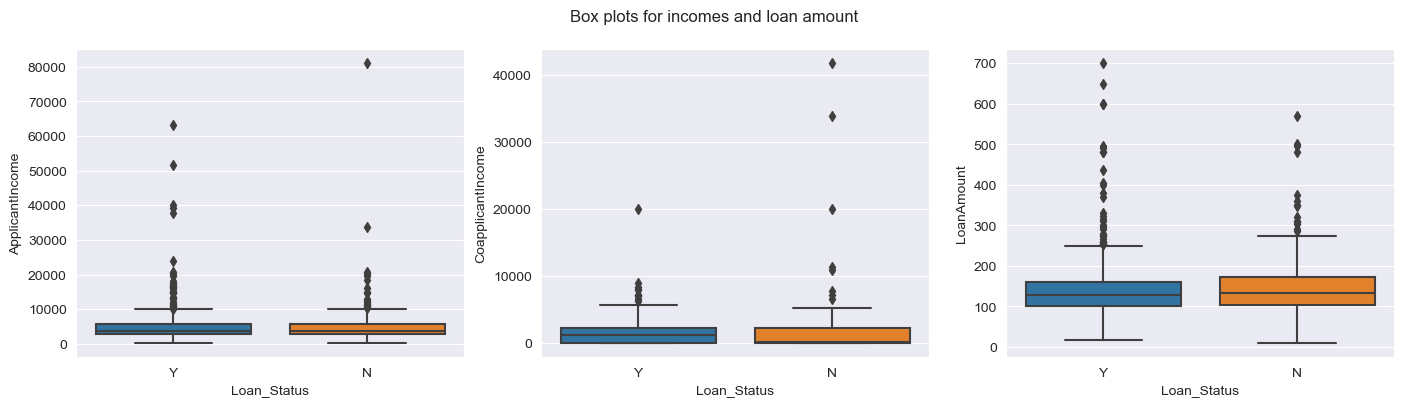

In [32]:
fig, axes = plt.subplots(1, 3, figsize = (17, 4))
fig.suptitle('Box plots for incomes and loan amount')

sns.boxplot(ax = axes[0], x = df['Loan_Status'], y = df['ApplicantIncome'])
sns.boxplot(ax = axes[1], x = df['Loan_Status'], y = df['CoapplicantIncome'])
sns.boxplot(ax = axes[2], x = df['Loan_Status'], y = df['LoanAmount'])

plt.show()

As we suspected earlier, the numerical variables have extreme values and a right-skewed distribution.

# Classification with Machine Learning algorithms

## Preprocessing data

We need to encode some variables to format understandable for algorithms.

In [33]:
df = pd.get_dummies(df)

In [34]:
df = df.drop(['Gender_Female', 'Married_No', 'Education_Not Graduate', 
              'Self_Employed_No', 'Loan_Status_N'], axis = 1)

In [35]:
dummy_names = {
    'Gender_Male': 'Gender', 'Married_Yes': 'Married', 
    'Education_Graduate': 'Education', 'Self_Employed_Yes': 'Self_Employed',
    'Loan_Status_Y': 'Loan_Status'
}
       
df.rename(columns = dummy_names, inplace = True)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ApplicantIncome          614 non-null    int64  
 1   CoapplicantIncome        614 non-null    float64
 2   LoanAmount               614 non-null    float64
 3   Loan_Amount_Term         614 non-null    int32  
 4   Credit_History           614 non-null    float64
 5   Gender                   614 non-null    uint8  
 6   Married                  614 non-null    uint8  
 7   Dependents_0             614 non-null    uint8  
 8   Dependents_1             614 non-null    uint8  
 9   Dependents_2             614 non-null    uint8  
 10  Dependents_3+            614 non-null    uint8  
 11  Education                614 non-null    uint8  
 12  Self_Employed            614 non-null    uint8  
 13  Property_Area_Rural      614 non-null    uint8  
 14  Property_Area_Semiurban  6

We should remove the extreme values by the IQR method and apply the square root transformation.

In [37]:
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)

IQR = q3 - q1

In [38]:
# remove outliers
df = df[~((df < (q1 - 1.5 * IQR)) | (df > (q3 + 1.5 * IQR))).any(axis = 1)]

In [39]:
# square root transformation

df['ApplicantIncome'] = np.sqrt(df['ApplicantIncome'])
df['CoapplicantIncome'] = np.sqrt(df['CoapplicantIncome'])
df['LoanAmount'] = np.sqrt(df['LoanAmount'])

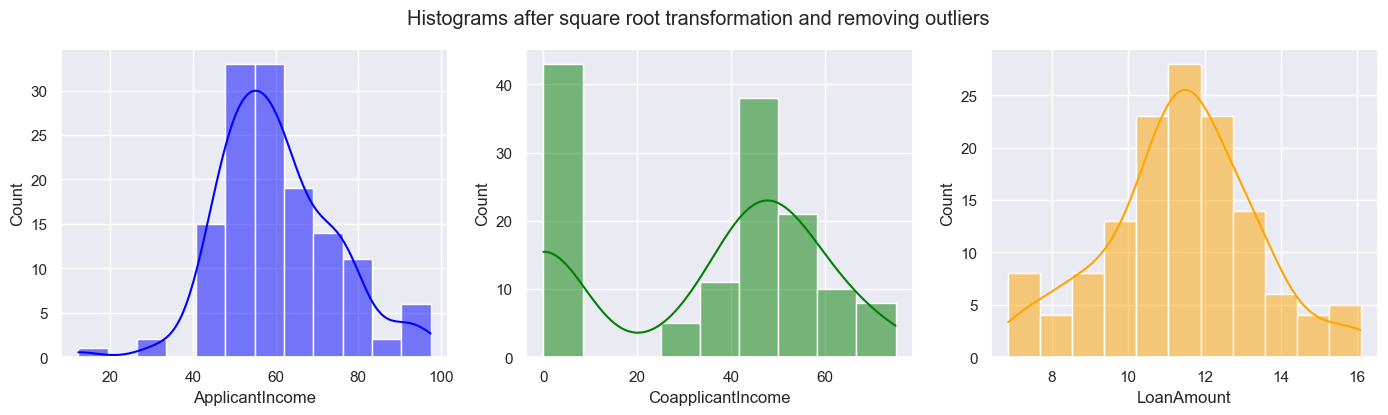

In [40]:
sns.set(style = 'darkgrid')
fig, axes = plt.subplots(1, 3, figsize = (17, 4))
fig.suptitle('Histograms after square root transformation and removing outliers')

sns.histplot(ax = axes[0], x = df['ApplicantIncome'], color = 'blue', kde = True)
sns.histplot(ax = axes[1], x = df['CoapplicantIncome'], color = 'green', kde = True)
sns.histplot(ax = axes[2], x = df['LoanAmount'], color = 'orange', kde = True)

plt.show()

It looks definitely better now.

## Defining features and target values

In [41]:
# creating X containing features and Y as target variable

X = df.drop(['Loan_Status'], axis = 1)
y = df['Loan_Status']

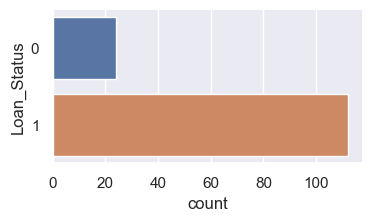

In [42]:
fig = plt.figure(figsize = (4, 2))
sns.countplot(y = y)
plt.show()

In [43]:
print('Target variable proportions (%):')
y.value_counts(normalize = True)

Target variable proportions (%):


1    0.823529
0    0.176471
Name: Loan_Status, dtype: float64

Dataset is very unbalanced so we will use oversampling method.

In [44]:
X, y = SMOTE(random_state = 1).fit_resample(X, y)

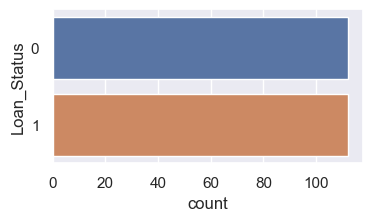

In [45]:
fig = plt.figure(figsize = (4, 2))
sns.countplot(y = y)
plt.show()

In [46]:
print('Target variable proportions after oversampling (%):')
y.value_counts(normalize = True)

Target variable proportions after oversampling (%):


1    0.5
0    0.5
Name: Loan_Status, dtype: float64

Now we use normalization using ```MinMaxScaler```.

In [47]:
X_cols = X.columns

In [48]:
X = MinMaxScaler().fit_transform(X)

In [49]:
X = pd.DataFrame(X, columns = X_cols)

In [50]:
# splitting the data into training and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 87)

## Random Forest Classifier

In [51]:
RF_Classifier = RandomForestClassifier()
RF_Classifier.fit(X_train, y_train)

RF_pred = RF_Classifier.predict(X_test)

In [52]:
print(f'Training data score: {RF_Classifier.score(X_train, y_train)}\nTest data score: {RF_Classifier.score(X_test, y_test)}')

Training data score: 1.0
Test data score: 0.8571428571428571


In [53]:
print(classification_report(y_test, RF_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        27
           1       0.86      0.86      0.86        29

    accuracy                           0.86        56
   macro avg       0.86      0.86      0.86        56
weighted avg       0.86      0.86      0.86        56



In [54]:
print(confusion_matrix(y_test, RF_pred))

[[23  4]
 [ 4 25]]


In [55]:
RF_params = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [6, 12, 18],
    'max_leaf_nodes': [6, 12, 18]
}

In [56]:
RF_Grid = GridSearchCV(RandomForestClassifier(), RF_params, n_jobs = -1)
RF_Grid.fit(X_train, y_train)

print(RF_Grid.best_params_)

{'max_depth': 12, 'max_leaf_nodes': 18, 'n_estimators': 500}


In [57]:
print(f'Training data score: {RF_Grid.score(X_train, y_train)}\nTest data score: {RF_Grid.score(X_test, y_test)}')

Training data score: 0.9702380952380952
Test data score: 0.8928571428571429


In [58]:
RF_RandomSearch = RandomizedSearchCV(RandomForestClassifier(), RF_params)
RF_RandomSearch.fit(X_train, y_train)

print(RF_RandomSearch.best_params_)

{'n_estimators': 1000, 'max_leaf_nodes': 18, 'max_depth': 12}


In [59]:
print(f'Training data score: {RF_RandomSearch.score(X_train, y_train)}\nTest data score: {RF_RandomSearch.score(X_test, y_test)}')

Training data score: 0.9642857142857143
Test data score: 0.8928571428571429


In [62]:
RF_model = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 18, max_depth = 12)
RF_model.fit(X_train, y_train)

RF_pred = RF_model.predict(X_test)

In [63]:
print(f'Training data score: {RF_model.score(X_train, y_train)}\nTest data score: {RF_model.score(X_test, y_test)}')

Training data score: 0.9642857142857143
Test data score: 0.9285714285714286


In [64]:
print(classification_report(y_test, RF_pred))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92        27
           1       0.90      0.97      0.93        29

    accuracy                           0.93        56
   macro avg       0.93      0.93      0.93        56
weighted avg       0.93      0.93      0.93        56



In [65]:
print(confusion_matrix(y_test, RF_pred))

[[24  3]
 [ 1 28]]


In [66]:
RF_Acc = (accuracy_score(y_test, RF_pred) * 100).round(2)
RF_f1 = (f1_score(y_test, RF_pred) * 100).round(2)

In [67]:
RF_pred_probs = RF_model.predict_proba(X_test)[:, 1]

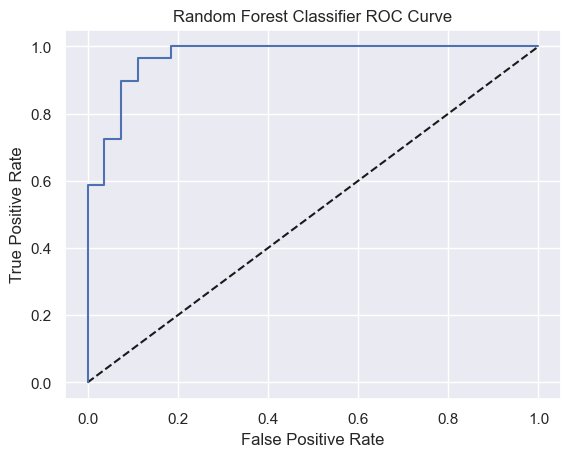

In [68]:
fpr, tpr, thresholds = roc_curve(y_test, RF_pred_probs)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Classifier ROC Curve')

plt.show()

In [69]:
print(f'AUC Score: {roc_auc_score(y_test, RF_pred_probs).round(2)}')

AUC Score: 0.97


In [70]:
importances = RF_model.feature_importances_
columns = X_train.columns

i = 0

while i < len(columns):
    print(f" The importance of feature '{columns[i]}' is {round(importances[i] * 100, 2)}%.")
    i += 1

 The importance of feature 'ApplicantIncome' is 28.0%.
 The importance of feature 'CoapplicantIncome' is 15.67%.
 The importance of feature 'LoanAmount' is 22.28%.
 The importance of feature 'Loan_Amount_Term' is 0.0%.
 The importance of feature 'Credit_History' is 0.0%.
 The importance of feature 'Gender' is 0.0%.
 The importance of feature 'Married' is 7.88%.
 The importance of feature 'Dependents_0' is 0.0%.
 The importance of feature 'Dependents_1' is 0.0%.
 The importance of feature 'Dependents_2' is 0.0%.
 The importance of feature 'Dependents_3+' is 0.0%.
 The importance of feature 'Education' is 0.0%.
 The importance of feature 'Self_Employed' is 0.0%.
 The importance of feature 'Property_Area_Rural' is 6.87%.
 The importance of feature 'Property_Area_Semiurban' is 14.65%.
 The importance of feature 'Property_Area_Urban' is 4.64%.


## Logistic Regression

In [71]:
LR_Classifier = LogisticRegression()
LR_Classifier.fit(X_train, y_train)

LR_pred = LR_Classifier.predict(X_test)

In [72]:
print(f'Training data score: {LR_Classifier.score(X_train, y_train)}\nTest data score: {LR_Classifier.score(X_test, y_test)}')

Training data score: 0.7321428571428571
Test data score: 0.8214285714285714


In [73]:
print(classification_report(y_test, LR_pred))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82        27
           1       0.85      0.79      0.82        29

    accuracy                           0.82        56
   macro avg       0.82      0.82      0.82        56
weighted avg       0.82      0.82      0.82        56



In [74]:
LR_Acc = (accuracy_score(y_test, LR_pred) * 100).round(2)
LR_f1 = (f1_score(y_test, LR_pred) * 100).round(2)

## XGBoost

In [75]:
XGB_Classifier = xgb.XGBClassifier()
XGB_Classifier.fit(X_train, y_train)

XGB_pred = XGB_Classifier.predict(X_test)

In [76]:
print(f'Training data score: {XGB_Classifier.score(X_train, y_train)}\nTest data score: {XGB_Classifier.score(X_test, y_test)}')

Training data score: 1.0
Test data score: 0.8928571428571429


In [77]:
print(classification_report(y_test, XGB_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        27
           1       0.90      0.90      0.90        29

    accuracy                           0.89        56
   macro avg       0.89      0.89      0.89        56
weighted avg       0.89      0.89      0.89        56



In [78]:
print(confusion_matrix(y_test, XGB_pred))

[[24  3]
 [ 3 26]]


In [79]:
XGB_params = {
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'learning_rate': [0.3, 0.6, 0.9],
    'max_depth': [3, 6, 9],
    'subsample': [0.3, 0.5, 1],
    'n_estimators': [50, 100, 500]
}

In [80]:
XGB_RandomSearch = RandomizedSearchCV(xgb.XGBClassifier(), XGB_params, n_jobs = -1)
XGB_RandomSearch.fit(X_train, y_train)

print(XGB_RandomSearch.best_params_)

{'subsample': 1, 'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 0.001}


In [81]:
print(f'Training data score: {XGB_RandomSearch.score(X_train, y_train)}\nTest data score: {XGB_RandomSearch.score(X_test, y_test)}')

Training data score: 1.0
Test data score: 0.8928571428571429


In [82]:
XGB_Acc = (accuracy_score(y_test, XGB_pred) * 100).round(2)
XGB_f1 = (f1_score(y_test, XGB_pred) * 100).round(2)

In [83]:
XGB_pred_probs = XGB_Classifier.predict_proba(X_test)[:, 1]

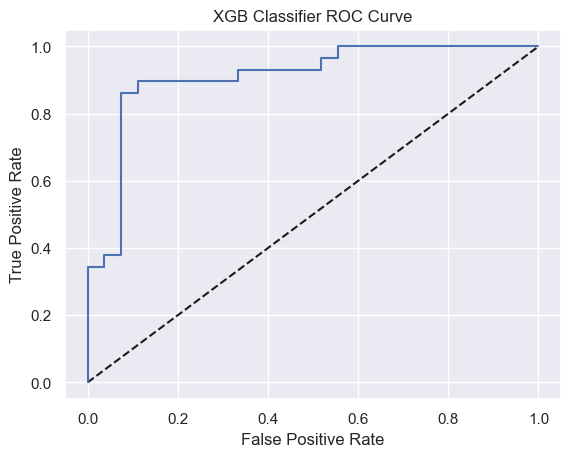

In [84]:
fpr, tpr, thresholds = roc_curve(y_test, XGB_pred_probs)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier ROC Curve')

plt.show()

In [85]:
print(f'AUC Score: {roc_auc_score(y_test, XGB_pred_probs).round(2)}')

AUC Score: 0.91


In [86]:
XGB_Classifier.get_booster().get_score(importance_type = 'weight')

{'ApplicantIncome': 261.0,
 'CoapplicantIncome': 147.0,
 'LoanAmount': 164.0,
 'Married': 28.0,
 'Property_Area_Rural': 28.0,
 'Property_Area_Semiurban': 29.0,
 'Property_Area_Urban': 34.0}

## Support Vector Machine

In [87]:
SVC_Classifier = SVC()

SVC_Classifier.fit(X_train, y_train)

SVC_pred = SVC_Classifier.predict(X_test)

In [88]:
print(f'Training data score: {SVC_Classifier.score(X_train, y_train)}\nTest data score: {SVC_Classifier.score(X_test, y_test)}')

Training data score: 0.7916666666666666
Test data score: 0.8214285714285714


In [89]:
print(classification_report(y_test, SVC_pred))

              precision    recall  f1-score   support

           0       0.84      0.78      0.81        27
           1       0.81      0.86      0.83        29

    accuracy                           0.82        56
   macro avg       0.82      0.82      0.82        56
weighted avg       0.82      0.82      0.82        56



In [90]:
SVC_Acc = (accuracy_score(y_test, SVC_pred) * 100).round(2)
SVC_f1 = (f1_score(y_test, SVC_pred) * 100).round(2)

## Decision Tree Classifier

In [91]:
DT_Classifier = DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = 18)
DT_Classifier.fit(X_train, y_train)

DT_pred = DT_Classifier.predict(X_test)

In [92]:
print(f'Training data score: {DT_Classifier.score(X_train, y_train)}\nTest data score: {DT_Classifier.score(X_test, y_test)}')

Training data score: 0.8988095238095238
Test data score: 0.9107142857142857


In [93]:
print(classification_report(y_test, DT_pred))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91        27
           1       0.90      0.93      0.92        29

    accuracy                           0.91        56
   macro avg       0.91      0.91      0.91        56
weighted avg       0.91      0.91      0.91        56



In [94]:
DT_Acc = (accuracy_score(y_test, DT_pred) * 100).round(2)
DT_f1 = (f1_score(y_test, DT_pred) * 100).round(2)

In [95]:
print(confusion_matrix(y_test, DT_pred))

[[24  3]
 [ 2 27]]


## K-Nearest Neighbors

In [96]:
knn_train_accuracies = {}
knn_test_accuracies = {}
neighbors = np.arange(1, 26)

In [97]:
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(X_train, y_train)
    knn_train_accuracies[n] = knn.score(X_train, y_train)
    knn_test_accuracies[n] = knn.score(X_test, y_test)

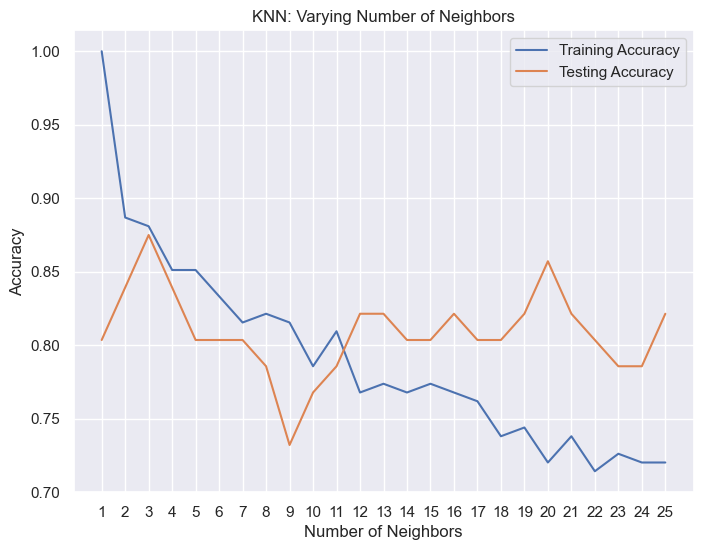

In [98]:
plt.figure(figsize = (8, 6))
plt.title("KNN: Varying Number of Neighbors")
plt.plot(neighbors, knn_train_accuracies.values(), label = "Training Accuracy")
plt.plot(neighbors, knn_test_accuracies.values(), label = "Testing Accuracy")
plt.xticks(np.arange(1, 26))
plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

In [99]:
KNN_Classifier = KNeighborsClassifier(n_neighbors = 3)
KNN_Classifier.fit(X_train, y_train)

KNN_pred = KNN_Classifier.predict(X_test)

In [100]:
print(f'Training data score: {KNN_Classifier.score(X_train, y_train)}\nTest data score: {KNN_Classifier.score(X_test, y_test)}')

Training data score: 0.8809523809523809
Test data score: 0.875


In [101]:
print(classification_report(y_test, KNN_pred))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86        27
           1       0.84      0.93      0.89        29

    accuracy                           0.88        56
   macro avg       0.88      0.87      0.87        56
weighted avg       0.88      0.88      0.87        56



In [102]:
print(confusion_matrix(y_test, KNN_pred))

[[22  5]
 [ 2 27]]


In [103]:
KNN_Acc = (accuracy_score(y_test, KNN_pred) * 100).round(2)
KNN_f1 = (f1_score(y_test, KNN_pred) * 100).round(2)

In [104]:
KNN_pred_probs = KNN_Classifier.predict_proba(X_test)[:, 1]

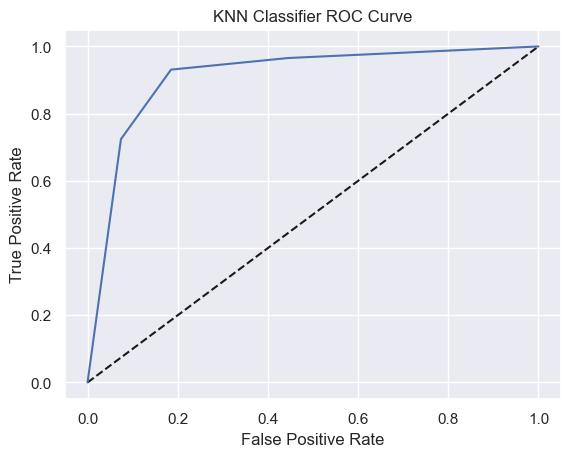

In [105]:
fpr, tpr, thresholds = roc_curve(y_test, KNN_pred_probs)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN Classifier ROC Curve')

plt.show()

In [106]:
print(f'AUC Score: {roc_auc_score(y_test, KNN_pred_probs).round(2)}')

AUC Score: 0.91


## KFold Cross Validation

In [107]:
cv = KFold(n_splits = 10, random_state = 1, shuffle = True)

In [108]:
scores = cross_val_score(RandomForestClassifier(n_estimators = 1000, max_leaf_nodes = 18, max_depth = 12), X, y, cv = cv, n_jobs = -1)

In [109]:
print('Cross Validation accuracy scores: %s' % scores)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores: [0.82608696 0.7826087  0.86956522 0.7826087  0.90909091 0.86363636
 0.72727273 0.86363636 0.72727273 0.86363636]
Cross Validation accuracy: 0.822 +/- 0.060


# Conclusion

In [110]:
model_names = ['Random Forest Classifier', 'Logistic Regression', 'XGBoost', 'Decision Tree Classifier', 'SVM', 'K-Nearest Neighbors']

model_scores = pd.DataFrame({
    'Accuracy': [RF_Acc, LR_Acc, XGB_Acc, DT_Acc, SVC_Acc, KNN_Acc],
    'F1-Score': [RF_f1, LR_f1, XGB_f1, DT_f1, SVC_f1, KNN_f1]
}, index = model_names)

model_scores.sort_values(by = 'Accuracy', ascending = False)

,Accuracy,F1-Score
Random Forest Classifier,92.86,93.33
Decision Tree Classifier,91.07,91.53
XGBoost,89.29,89.66
K-Nearest Neighbors,87.50,88.52
Logistic Regression,82.14,82.14
SVM,82.14,83.33


The best algorithm for these data turned out to be **Random Forest Classifier**.\
Its accuracy was about **93%**. The F1 Score combining precision and recall proves the high performance of the classification.

All models achieved accuracy above 80%. Moreover, their F1 scores confirm that they were rarely wrong.

Variables that had the greatest impact on the models:
1. **Applicant_Income**
2. **LoanAmount**
3. **Coapplicant_Income**